### Colocating gridded data with discrete observations

This notebook gives an introduction into collocation of gridded data with observations. Here, the 550 nm AODs of the ECMWF CAMS reanalysis model are compared with global daily AeroNet Sun V2 (Level 2) data for the year 2010. The collocated data will be analysed and visualised in monthly resolution. The analysis results will be plotted in the form of the well known Aerocom loglog scatter plots as can be found in the online interface (see e.g. [here](http://aerocom.met.no/cgi-bin/aerocom/surfobs_annualrs.pl)).

#### Import setup and imports

In [1]:
import pyaerocom as pya
pya.change_verbosity('critical')

YEAR = 2010
VAR = "od550aer"
TS_TYPE = "daily"
MODEL_ID = "ECMWF_CAMS_REAN"
OBS_ID = 'AeronetSunV3Lev2.daily'

Init data paths for lustre


0.007446765899658203 s


#### Import of model data

Create reader instance for model data and print overview of what is in there.

In [2]:
model_reader = pya.io.ReadGridded(MODEL_ID)
print(model_reader)


Pyaerocom ReadGridded
---------------------
Model ID: ECMWF_CAMS_REAN
Data directory: /lustre/storeA/project/aerocom/aerocom-users-database/ECMWF/ECMWF_CAMS_REAN/renamed
Available variables: ['ang4487aer', 'od440aer', 'od550aer', 'od550bc', 'od550dust', 'od550oa', 'od550so4', 'od550ss', 'od865aer']
Available years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 9999]
Available time resolutions ['daily', 'monthly']


Since we are only interested in a single year we can use the method

In [3]:
model_data = model_reader.read_var(VAR, start=YEAR)
#model_data = read_result[VAR][YEAR]
print(model_data)

/home/jonasg/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2029: UserWarning: Gracefully filling 'lat' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/jonasg/anaconda3/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2029: UserWarning: Gracefully filling 'lon' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))


pyaerocom.GriddedData: ECMWF_CAMS_REAN
Grid data: Aerosol optical depth at 550 nm / (1) (time: 365; latitude: 161; longitude: 320)
     Dimension coordinates:
          time                             x              -               -
          latitude                         -              x               -
          longitude                        -              -               x
     Attributes:
          Conventions: CF-1.6
          NCO: "4.5.4"
          history: Sat May 26 21:08:48 2018: ncecat -O -u time -n 365,3,1 CAMS_REAN_001.nc...
          nco_openmp_thread_number: 1
     Cell methods:
          mean: step
          mean: time


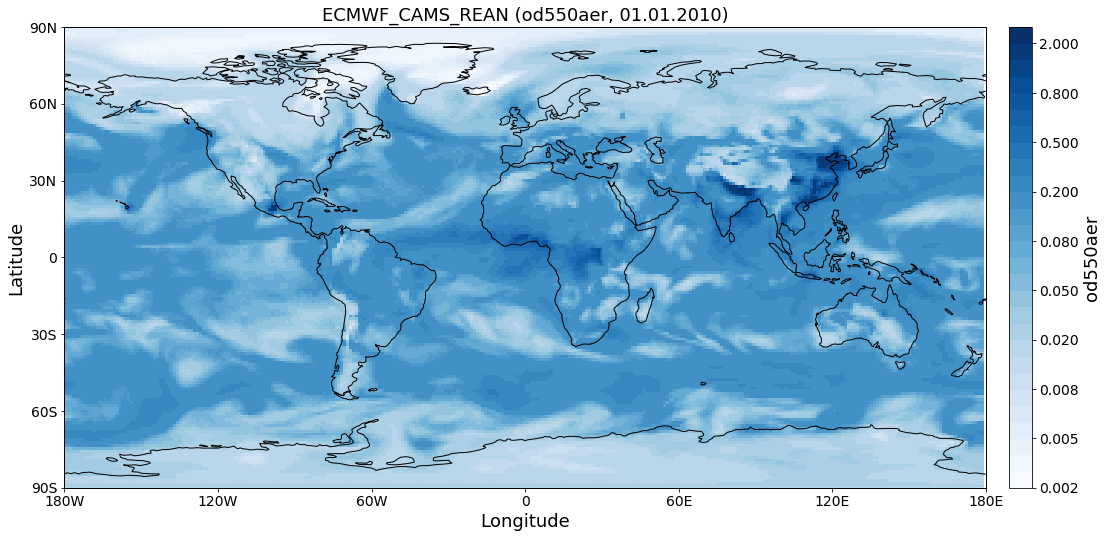

In [4]:
fig = model_data.quickplot_map(time_idx=0)

#### Import of AeroNet Sun V3 data (Level 2)

Import Aeronet data and apply filter that selects only stations that are located at altitudes between 0 and 1000 m.

In [5]:
obs_reader = pya.io.ReadUngridded(OBS_ID, [VAR, 'ang4487aer'])
obs_data = obs_reader.read().filter_by_meta(stat_alt=[0, 1000])
print(obs_data)

Found Cache match for AeronetSunV3Lev2.daily



Pyaerocom UngriddedData
-----------------------
Contains networks: ['AeronetSunV3Lev2.daily']
Contains variables: ['ang4487aer', 'od550aer']
Contains instruments: ['sun_photometer']
Total no. of meta-blocks: 1006
Filters that were applied:
 Filter time log: 20181121163558
	stat_alt: [0, 1000]


#### Plot station coordinates

First, plot all stations that are available at all times (as red dots), then (on top of that in green), plot all stations that provide AODs in 2010.

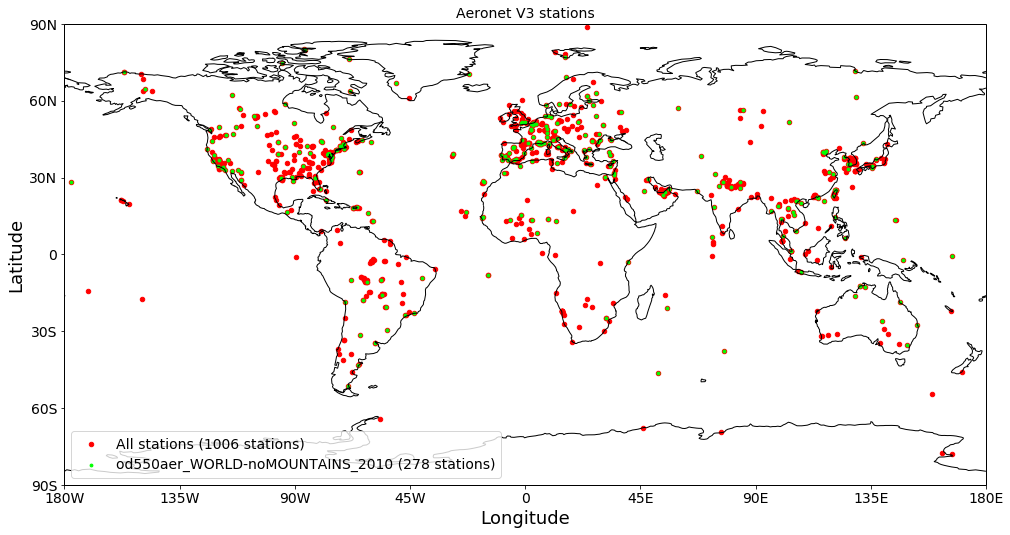

In [6]:
ax = obs_data.plot_station_coordinates(color='r', markersize=20,
                                       label='All stations')
ax = obs_data.plot_station_coordinates(var_name='od550aer', start=2010, 
                                       filter_name='WORLD-noMOUNTAINS',
                                       color='lime', markersize=8, legend=True,
                                       title='Aeronet V3 stations',
                                       ax=ax) #just pass the GeoAxes instance that was created in the first call

#### Now perform collocation and plot corresponding scatter plots with statistical values

##### 2010 monthly World no mountains

Colocate 2010 data in monthly resolution using (cf. green dots in station plot above).

In [7]:
obs_data

UngriddedData <networks: ['AeronetSunV3Lev2.daily']; vars: ['ang4487aer', 'od550aer']; instruments: ['sun_photometer'];No. of stations: 1006

In [8]:
data_coloc = pya.colocation.colocate_gridded_ungridded(model_data, obs_data, ts_type='monthly',
                                                       filter_name='WORLD-noMOUNTAINS')
data_coloc

Interpolating data of shape (12, 161, 320). This may take a while.


Successfully interpolated cube


<xarray.DataArray 'od550aer' (data_source: 2, time: 12, station_name: 278)>
array([[[     nan, 0.117588, ...,      nan,      nan],
        [     nan, 0.132128, ...,      nan,      nan],
        ...,
        [0.132236, 0.195057, ...,      nan,      nan],
        [     nan, 0.098409, ...,      nan,      nan]],

       [[0.189948, 0.140062, ..., 0.079353, 0.204337],
        [0.150408, 0.190089, ..., 0.10622 , 0.257806],
        ...,
        [0.159844, 0.178564, ..., 0.054091, 0.239393],
        [0.147172, 0.138039, ..., 0.077916, 0.19986 ]]])
Coordinates:
  * data_source   (data_source) <U22 'AeronetSunV3Lev2.daily' 'ECMWF_CAMS_REAN'
    var_name      (data_source) <U8 'od550aer' 'od550aer'
  * time          (time) datetime64[ns] 2010-01-01 2010-02-01 2010-03-01 ...
  * station_name  (station_name) <U19 'ARM_Darwin' 'ATHENS-NOA' 'Agoufou' ...
    latitude      (station_name) float64 -12.43 37.97 15.35 -9.871 42.02 ...
    longitude     (station_name) float64 130.9 23.72 -1.479 -56.1 -93.7

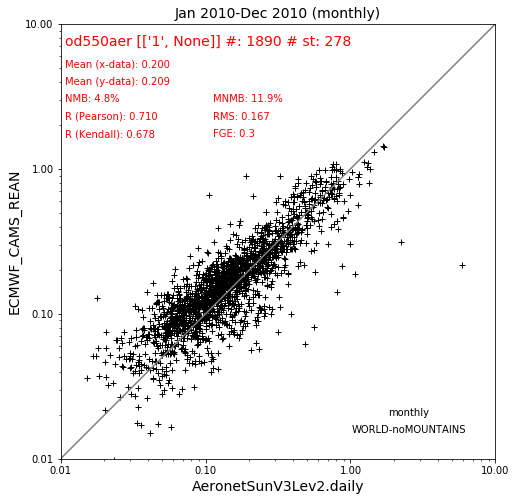

In [9]:
data_coloc.plot_scatter()

##### 2010 daily Europe no mountains

Now perform colocation only over Europe. Starting with a station plot.

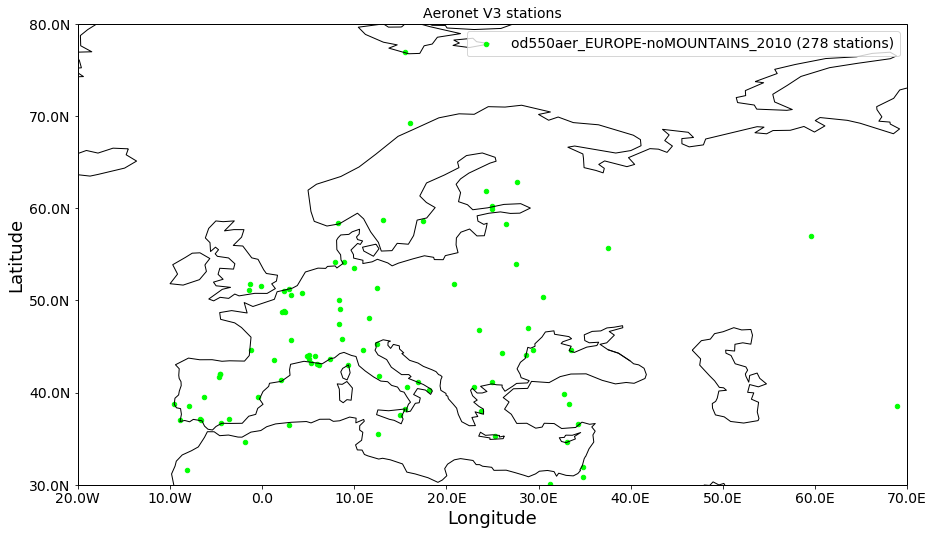

In [10]:
obs_data.plot_station_coordinates(var_name='od550aer', start=2010, 
                                  filter_name='EUROPE-noMOUNTAINS',
                                  color='lime', markersize=20, legend=True,
                                  title='Aeronet V3 stations')

In [11]:
data_coloc = pya.colocation.colocate_gridded_ungridded_2D(model_data, obs_data, ts_type='daily',
                                                             filter_name='EUROPE-noMOUNTAINS')
data_coloc

Old name of function colocate_gridded_ungridded(still works)


Interpolating data of shape (365, 161, 320). This may take a while.


Successfully interpolated cube


<xarray.DataArray 'od550aer' (data_source: 2, time: 365, station_name: 89)>
array([[[0.163447,      nan, ...,      nan,      nan],
        [0.078648,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[0.086522, 0.015151, ..., 0.075447, 0.03005 ],
        [0.067198, 0.043074, ..., 0.103671, 0.042999],
        ...,
        [0.242585, 0.186407, ..., 0.053797, 0.011344],
        [0.079498, 0.122098, ..., 0.027066, 0.019639]]])
Coordinates:
  * data_source   (data_source) <U22 'AeronetSunV3Lev2.daily' 'ECMWF_CAMS_REAN'
    var_name      (data_source) <U8 'od550aer' 'od550aer'
  * time          (time) datetime64[ns] 2010-01-01 2010-01-02 2010-01-03 ...
  * station_name  (station_name) <U19 'ATHENS-NOA' 'Andenes' 'Arcachon' ...
    latitude      (station_name) float64 37.97 69.28 44.66 45.76 42.0 43.93 ...
    longitude     (station_name) float64 23.72 16.01 -1.163 3.111 -4.6

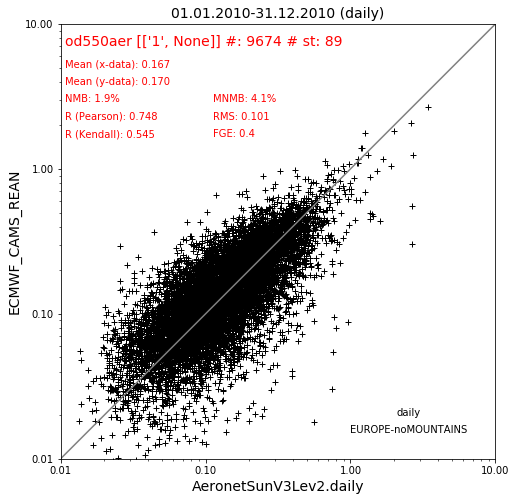

In [12]:
data_coloc.plot_scatter()